In [ ]:
# ==============================================================================
# 1. IMPORTS
# ==============================================================================
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models.catalog import ModelCatalog
from ray.rllib.utils.annotations import override

import or_gym
from or_gym.utils import create_env

from nodegam.arch import GAMBlock

class LibraryNODEGAM_RL(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)
        
        self.contribution_dim = 16  
        self.node_model = GAMBlock(
            in_features=obs_space.shape[0],
            num_trees=8,     
            num_layers=1,
            num_classes=self.contribution_dim,
            depth=2,         
            ga2m=1,         
            lam=0.0005       
        )
        self.actor_head = nn.Linear(self.contribution_dim, num_outputs)
        self.value_head = nn.Linear(self.contribution_dim, 1)
        self._last_total_contribution = None
        
        self._is_training = False

    def forward(self, input_dict, state, seq_lens):
        self._is_training = "is_training" not in input_dict or input_dict["is_training"]

        obs = input_dict["obs_flat"].float()
        total_contribution = self.node_model(obs)
        self._last_total_contribution = total_contribution
        logits = self.actor_head(total_contribution)
        return logits, state

    def value_function(self):
        assert self._last_total_contribution is not None
        value = self.value_head(self._last_total_contribution).squeeze(1)
        
        if not self._is_training:
            return value.cpu()
        return value

# Register the library-based model with RLlib
ModelCatalog.register_custom_model("library_nodegam", LibraryNODEGAM_RL)

# ==============================================================================
# 3. ENVIRONMENT AND RLlib CONFIGURATION
# ==============================================================================

def register_env(env_name, env_config={}):
    env_creator = create_env(env_name)
    tune.register_env(env_name, lambda config: env_creator(env_name, env_config=config))

env_name = 'NetworkManagement-v0'

env_config = {}

rl_config = dict(
    env=env_name,
    num_workers=0,
    env_config=env_config,
    model=dict(
        custom_model="library_nodegam",
        custom_model_config={},
    ),
    clip_actions=True, 
    vf_clip_param=650000.0,
    lr=1e-4,           
    entropy_coeff=0.02,
    num_sgd_iter=20,
    train_batch_size=4000,
    sgd_minibatch_size=128,
    horizon=200, 
    framework="torch",
    num_gpus=0,
)

register_env(env_name, env_config)

# ==============================================================================
# 4. TRAINING AND ANALYSIS
# ==============================================================================

ray.init(ignore_reinit_error=True)

print("Initializing PPOTrainer with NODE-GAM model...")
agent = PPOTrainer(env=env_name, config=rl_config)

results = []
print("Starting training...")
for i in range(300):
    res = agent.train()
    results.append(res)
    print(f"Iter: {i+1}\tReward: {res['episode_reward_mean']:.2f}")

print("\nTraining finished.")
checkpoint_path = agent.save()
print(f"\nAgent checkpoint saved at: {checkpoint_path}")



c:\Users\24608\anaconda3\envs\nodeor\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\24608\anaconda3\envs\nodeor\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\24608\anaconda3\envs\nodeor\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\24608\anaconda3\envs\nodeor\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Instructions for updating:
non-resource variables are not supported in the long term
WARNING! The apex is not installed so fp16 is not available.


2025-11-20 14:32:26,011	INFO services.py:1164 -- View the Ray dashboard at http://127.0.0.1:8265
2025-11-20 14:32:28,636	ERROR syncer.py:63 -- Log sync requires rsync to be installed.
2025-11-20 14:32:28,636	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Initializing PPOTrainer with NODE-GAM model...


c:\Users\24608\anaconda3\envs\nodeor\lib\site-packages\torch\cuda\__init__.py:104: UserWarning: 
NVIDIA GeForce RTX 4080 Laptop GPU with CUDA capability sm_89 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 4080 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))
2025-11-20 14:38:57,173	INFO trainable.py:252 -- Trainable.setup took 388.537 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2025-11-20 14:38:57,174	WARNING util.py:39 -- Install gputil for GPU system monitoring.
c:\Users\24608\anaconda3\envs\nodeor\lib\site-packages\nodegam\odst.py:145: UserWarning: Data-aware initialization is performed on less

Starting training...
Iter: 1	Reward: -781.95
Iter: 2	Reward: -561.73
Iter: 3	Reward: -556.13
Iter: 4	Reward: -553.98
Iter: 5	Reward: -532.87
Iter: 6	Reward: -535.17
Iter: 7	Reward: -536.00
Iter: 8	Reward: -542.39
Iter: 9	Reward: -555.47
Iter: 10	Reward: -537.36
Iter: 11	Reward: -548.45
Iter: 12	Reward: -548.76
Iter: 13	Reward: -534.12
Iter: 14	Reward: -532.02
Iter: 15	Reward: -540.52
Iter: 16	Reward: -527.10
Iter: 17	Reward: -512.47
Iter: 18	Reward: -520.52
Iter: 19	Reward: -506.91
Iter: 20	Reward: -507.68
Iter: 21	Reward: -499.94
Iter: 22	Reward: -498.91
Iter: 23	Reward: -509.92
Iter: 24	Reward: -495.45
Iter: 25	Reward: -467.38
Iter: 26	Reward: -486.67
Iter: 27	Reward: -476.48
Iter: 28	Reward: -479.92
Iter: 29	Reward: -467.94
Iter: 30	Reward: -454.27
Iter: 31	Reward: -455.84
Iter: 32	Reward: -460.67
Iter: 33	Reward: -440.95
Iter: 34	Reward: -442.00
Iter: 35	Reward: -425.38
Iter: 36	Reward: -432.00
Iter: 37	Reward: -437.97
Iter: 38	Reward: -429.26
Iter: 39	Reward: -430.18
Iter: 40	Rewa


Plotting training rewards and losses...


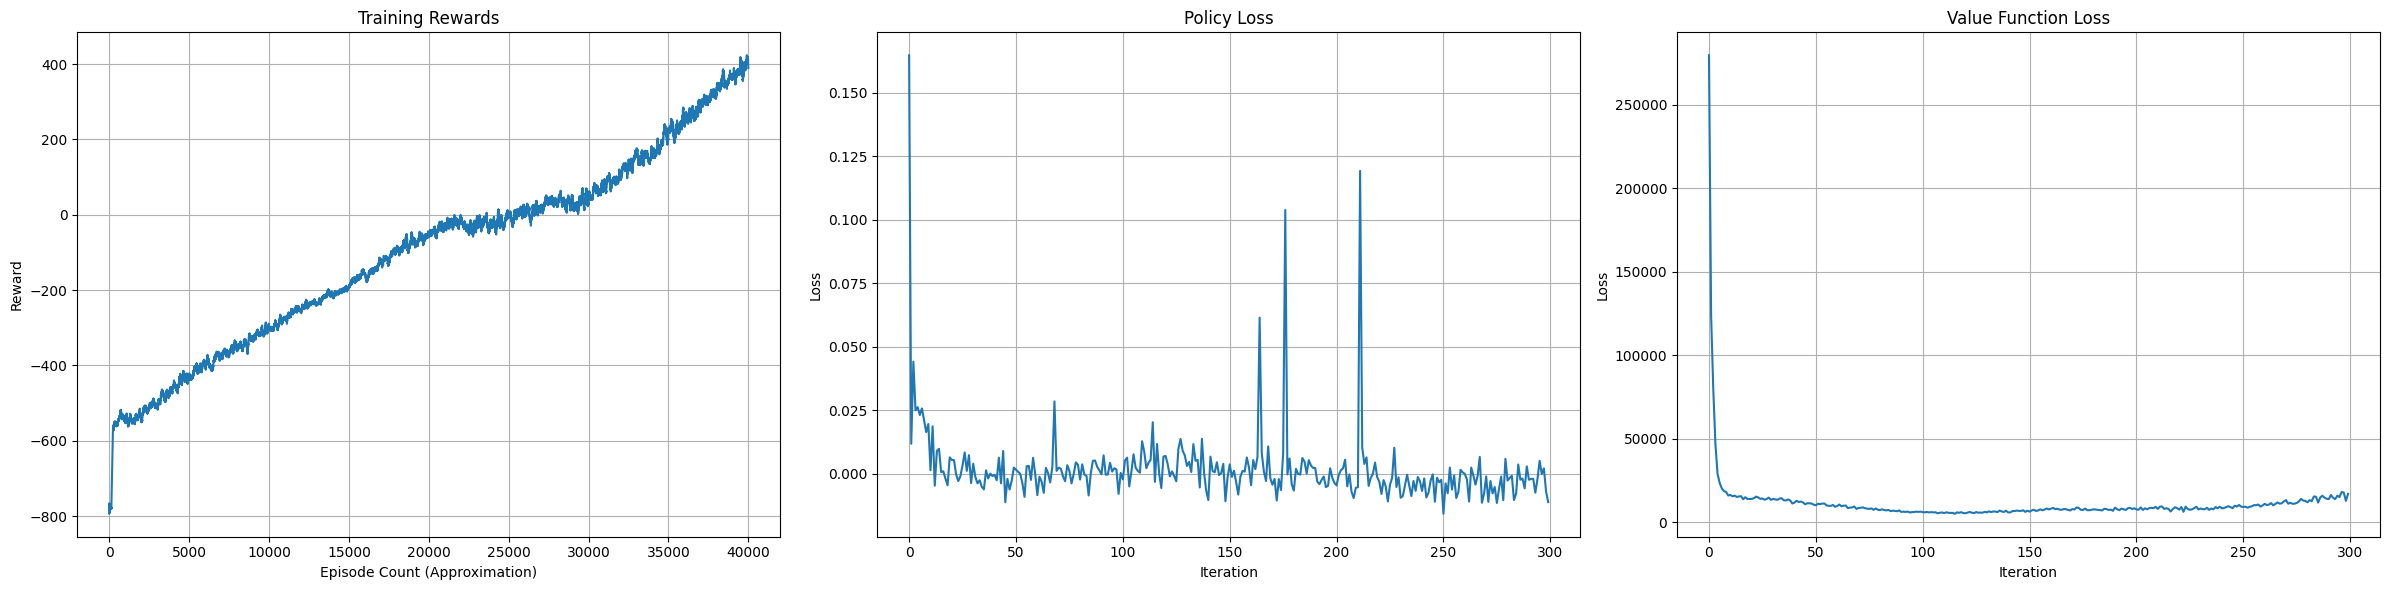


Training and results plotting complete.
The next step will be to use the 'extract_additive_terms' method on the trained agent to generate interpretability plots.

Shutting down Ray...


In [ ]:
print("\nPlotting training rewards and losses...")
rewards = np.hstack([i['hist_stats']['episode_reward'] for i in results])
mean_rewards = np.array([np.mean(rewards[i-100:i+1]) if i >= 100 else np.mean(rewards[:i+1]) for i, _ in enumerate(rewards)])
pol_loss = [i['info']['learner']['default_policy']['policy_loss'] for i in results]
vf_loss = []
for i in results:
    pol = i['info']['learner']['default_policy']


    if 'vf_loss' in pol:
        vf_loss.append(pol['vf_loss'])
    elif 'learner_stats' in pol and 'vf_loss' in pol['learner_stats']:
        vf_loss.append(pol['learner_stats']['vf_loss'])
    else:
        vf_loss.append(None)

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
axes[0].plot(mean_rewards, label='Mean Rewards')
axes[0].set_title('Training Rewards')
axes[0].set_xlabel('Episode Count (Approximation)')
axes[0].set_ylabel('Reward')
axes[0].grid(True)

axes[1].plot(pol_loss)
axes[1].set_title('Policy Loss')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

axes[2].plot(vf_loss)
axes[2].set_title('Value Function Loss')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Loss')
axes[2].grid(True)

plt.tight_layout()
plt.show()


print("\nTraining and results plotting complete.")
print("The next step will be to use the 'extract_additive_terms' method on the trained agent to generate interpretability plots.")

print("\nShutting down Ray...")
#ray.shutdown()

In [ ]:
for i in range(100):
    res = agent.train()
    results.append(res)
    print(f"Iter: {i+101}\tReward: {res['episode_reward_mean']:.2f}") #Typo, should be i+300

Iter: 101	Reward: 391.68
Iter: 102	Reward: 403.81
Iter: 103	Reward: 388.32
Iter: 104	Reward: 397.07
Iter: 105	Reward: 418.05
Iter: 106	Reward: 432.34
Iter: 107	Reward: 429.87
Iter: 108	Reward: 450.21
Iter: 109	Reward: 464.90
Iter: 110	Reward: 432.71
Iter: 111	Reward: 455.64
Iter: 112	Reward: 466.51
Iter: 113	Reward: 465.44
Iter: 114	Reward: 478.32
Iter: 115	Reward: 479.97
Iter: 116	Reward: 486.45
Iter: 117	Reward: 491.08
Iter: 118	Reward: 511.61
Iter: 119	Reward: 518.03
Iter: 120	Reward: 486.04
Iter: 121	Reward: 504.88
Iter: 122	Reward: 492.15
Iter: 123	Reward: 518.04
Iter: 124	Reward: 503.49
Iter: 125	Reward: 519.59
Iter: 126	Reward: 528.42
Iter: 127	Reward: 542.26
Iter: 128	Reward: 541.81
Iter: 129	Reward: 511.51
Iter: 130	Reward: 533.39
Iter: 131	Reward: 537.43
Iter: 132	Reward: 535.40
Iter: 133	Reward: 567.16
Iter: 134	Reward: 542.44
Iter: 135	Reward: 544.39
Iter: 136	Reward: 527.88
Iter: 137	Reward: 539.72
Iter: 138	Reward: 574.74
Iter: 139	Reward: 572.06
Iter: 140	Reward: 591.08



Plotting training rewards and losses...


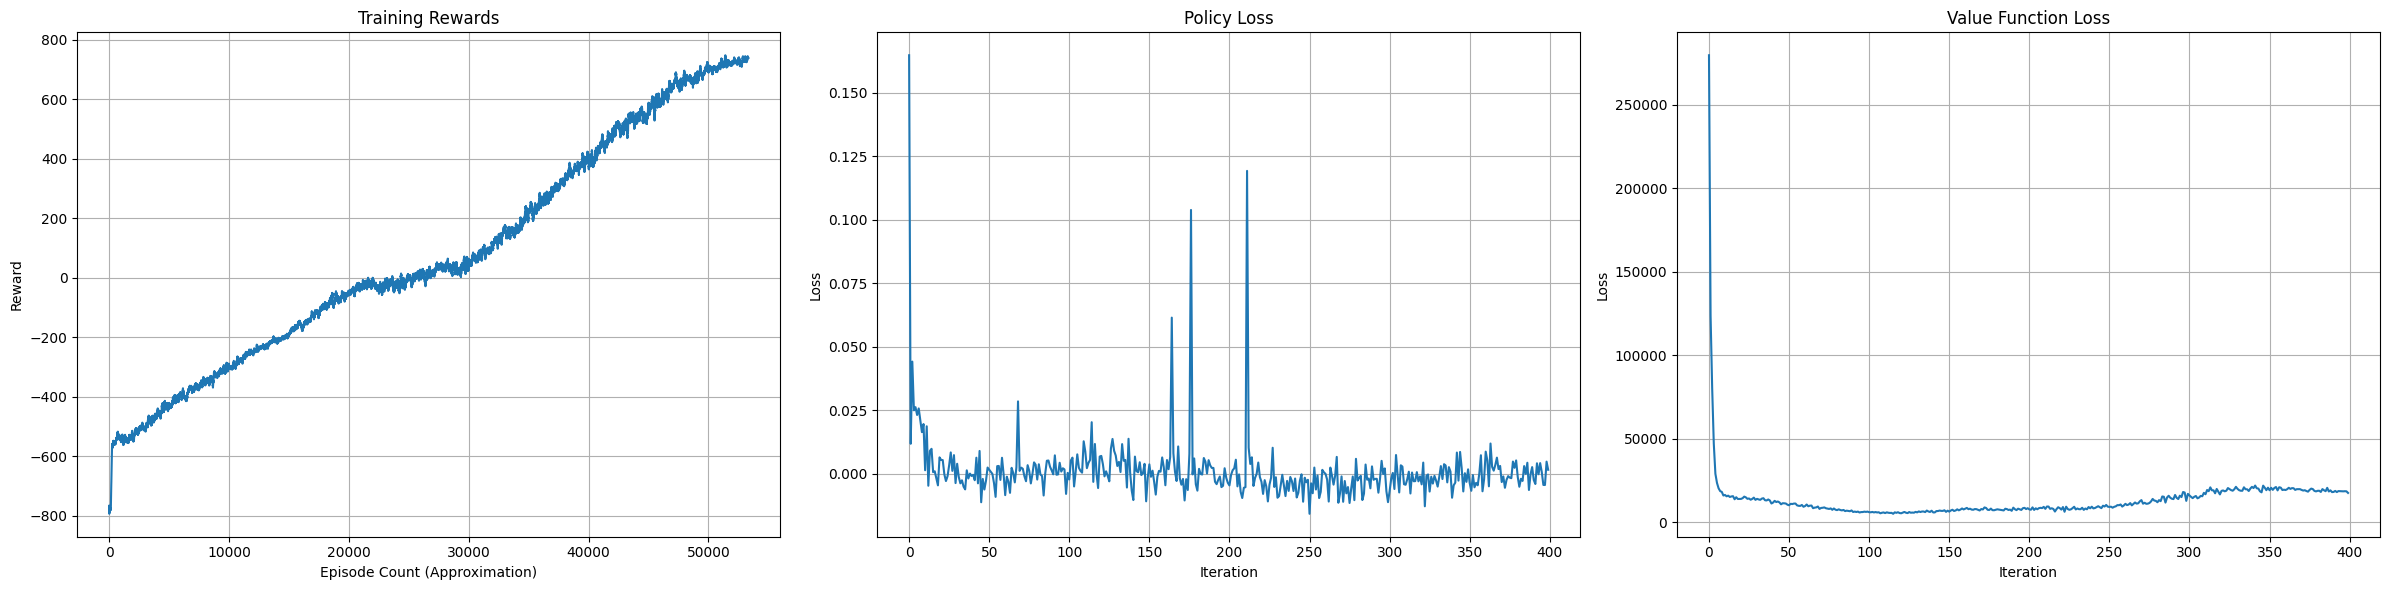


Training and results plotting complete.
The next step will be to use the 'extract_additive_terms' method on the trained agent to generate interpretability plots.

Shutting down Ray...


In [ ]:
print("\nPlotting training rewards and losses...")
rewards = np.hstack([i['hist_stats']['episode_reward'] for i in results])
mean_rewards = np.array([np.mean(rewards[i-100:i+1]) if i >= 100 else np.mean(rewards[:i+1]) for i, _ in enumerate(rewards)])
pol_loss = [i['info']['learner']['default_policy']['policy_loss'] for i in results]
vf_loss = []
for i in results:
    pol = i['info']['learner']['default_policy']


    if 'vf_loss' in pol:
        vf_loss.append(pol['vf_loss'])
    elif 'learner_stats' in pol and 'vf_loss' in pol['learner_stats']:
        vf_loss.append(pol['learner_stats']['vf_loss'])
    else:
        vf_loss.append(None)

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
axes[0].plot(mean_rewards, label='Mean Rewards')
axes[0].set_title('Training Rewards')
axes[0].set_xlabel('Episode Count (Approximation)')
axes[0].set_ylabel('Reward')
axes[0].grid(True)

axes[1].plot(pol_loss)
axes[1].set_title('Policy Loss')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

axes[2].plot(vf_loss)
axes[2].set_title('Value Function Loss')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Loss')
axes[2].grid(True)

plt.tight_layout()
plt.show()


print("\nTraining and results plotting complete.")
print("The next step will be to use the 'extract_additive_terms' method on the trained agent to generate interpretability plots.")

print("\nShutting down Ray...")
#ray.shutdown()

In [6]:
for i in range(100):
    res = agent.train()
    results.append(res)
    print(f"Iter: {i+401}\tReward: {res['episode_reward_mean']:.2f}")

Iter: 401	Reward: 726.42
Iter: 402	Reward: 731.62
Iter: 403	Reward: 728.75
Iter: 404	Reward: 736.43
Iter: 405	Reward: 727.74
Iter: 406	Reward: 720.63
Iter: 407	Reward: 738.93
Iter: 408	Reward: 735.24
Iter: 409	Reward: 740.91
Iter: 410	Reward: 732.74
Iter: 411	Reward: 727.94
Iter: 412	Reward: 729.93
Iter: 413	Reward: 738.59
Iter: 414	Reward: 734.42
Iter: 415	Reward: 725.40
Iter: 416	Reward: 729.56
Iter: 417	Reward: 730.28
Iter: 418	Reward: 731.32
Iter: 419	Reward: 742.01
Iter: 420	Reward: 734.88
Iter: 421	Reward: 727.31
Iter: 422	Reward: 730.68
Iter: 423	Reward: 739.24
Iter: 424	Reward: 730.57
Iter: 425	Reward: 726.26
Iter: 426	Reward: 730.45
Iter: 427	Reward: 738.32
Iter: 428	Reward: 733.39
Iter: 429	Reward: 722.24
Iter: 430	Reward: 733.63
Iter: 431	Reward: 724.37
Iter: 432	Reward: 729.51
Iter: 433	Reward: 731.59
Iter: 434	Reward: 737.52
Iter: 435	Reward: 736.62
Iter: 436	Reward: 736.54
Iter: 437	Reward: 726.85
Iter: 438	Reward: 729.35
Iter: 439	Reward: 726.44
Iter: 440	Reward: 734.99



Plotting training rewards and losses...


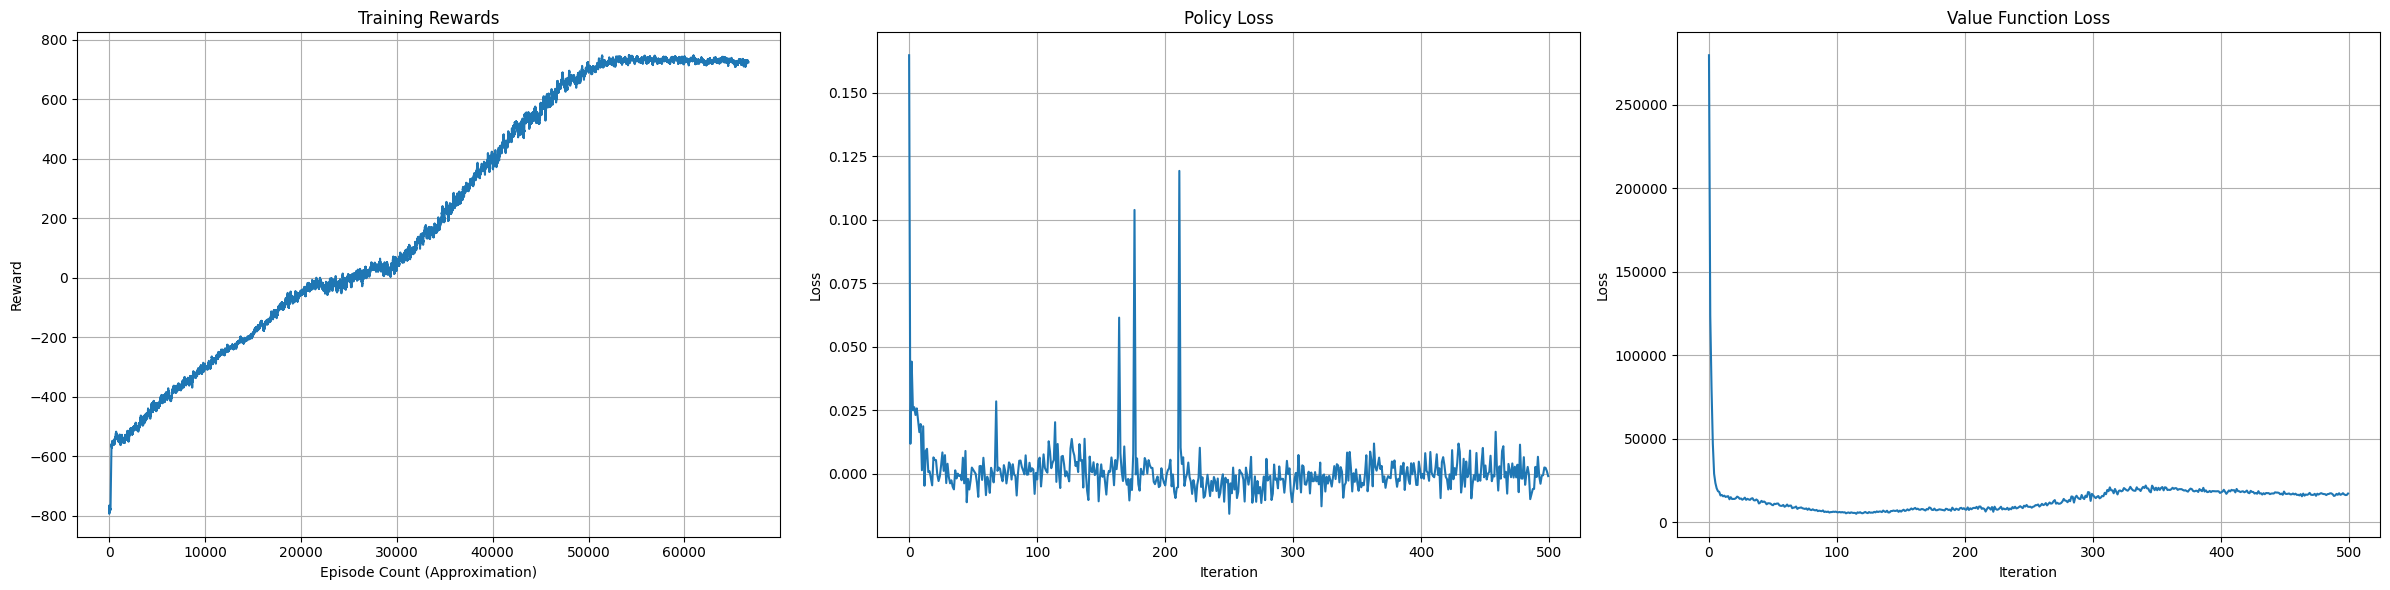


Training and results plotting complete.
The next step will be to use the 'extract_additive_terms' method on the trained agent to generate interpretability plots.

Shutting down Ray...


In [ ]:
print("\nPlotting training rewards and losses...")
rewards = np.hstack([i['hist_stats']['episode_reward'] for i in results])
mean_rewards = np.array([np.mean(rewards[i-100:i+1]) if i >= 100 else np.mean(rewards[:i+1]) for i, _ in enumerate(rewards)])
pol_loss = [i['info']['learner']['default_policy']['policy_loss'] for i in results]
vf_loss = []
for i in results:
    pol = i['info']['learner']['default_policy']


    if 'vf_loss' in pol:
        vf_loss.append(pol['vf_loss'])
    elif 'learner_stats' in pol and 'vf_loss' in pol['learner_stats']:
        vf_loss.append(pol['learner_stats']['vf_loss'])
    else:
        vf_loss.append(None)

fig, axes = plt.subplots(1, 3, figsize=(24, 6))
axes[0].plot(mean_rewards, label='Mean Rewards')
axes[0].set_title('Training Rewards')
axes[0].set_xlabel('Episode Count (Approximation)')
axes[0].set_ylabel('Reward')
axes[0].grid(True)

axes[1].plot(pol_loss)
axes[1].set_title('Policy Loss')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Loss')
axes[1].grid(True)

axes[2].plot(vf_loss)
axes[2].set_title('Value Function Loss')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Loss')
axes[2].grid(True)

plt.tight_layout()
plt.show()


print("\nTraining and results plotting complete.")
print("The next step will be to use the 'extract_additive_terms' method on the trained agent to generate interpretability plots.")

print("\nShutting down Ray...")
#ray.shutdown()

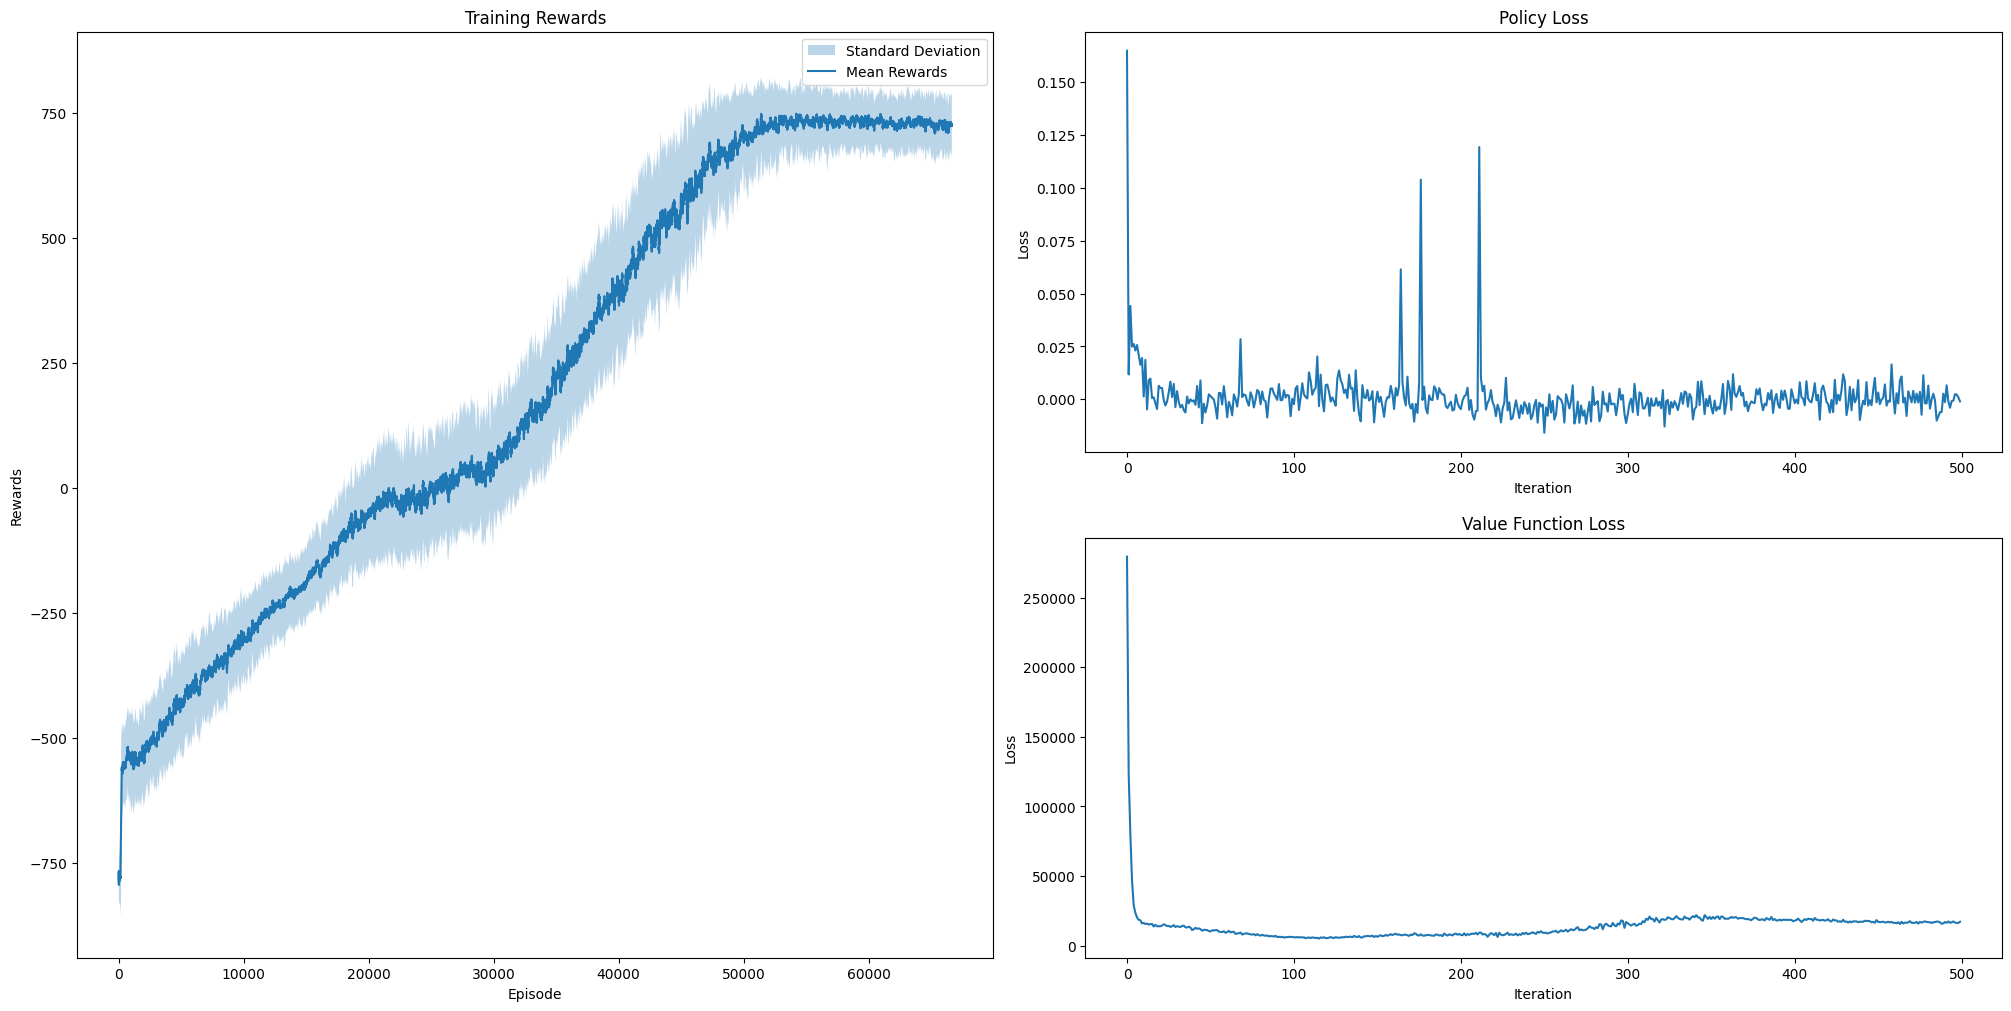

In [8]:
def plot_training_results(results):
    # Unpack values from each iteration
    rewards = np.hstack([i['hist_stats']['episode_reward'] for i in results])
    pol_loss = [i['info']['learner']['default_policy']['policy_loss'] for i in results]
    vf_loss = [i['info']['learner']['default_policy']['vf_loss'] for i in results]
    
    p = 100
    mean_rewards = np.array([np.mean(rewards[i-p:i+1]) 
                    if i >= p else np.mean(rewards[:i+1]) 
                    for i, _ in enumerate(rewards)])
    std_rewards = np.array([np.std(rewards[i-p:i+1])
                   if i >= p else np.std(rewards[:i+1])
                   for i, _ in enumerate(rewards)])
    
    fig = plt.figure(constrained_layout=True, figsize=(20, 10))
    gs = fig.add_gridspec(2, 4)
    ax0 = fig.add_subplot(gs[:, :-2])
    ax0.fill_between(np.arange(len(mean_rewards)), 
                     mean_rewards - std_rewards, 
                     mean_rewards + std_rewards, 
                     label='Standard Deviation', alpha=0.3)
    ax0.plot(mean_rewards, label='Mean Rewards')
    ax0.set_ylabel('Rewards')
    ax0.set_xlabel('Episode')
    ax0.set_title('Training Rewards')
    ax0.legend()
    
    ax1 = fig.add_subplot(gs[0, 2:])
    ax1.plot(pol_loss)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Iteration')
    ax1.set_title('Policy Loss')
    
    ax2 = fig.add_subplot(gs[1, 2:])
    ax2.plot(vf_loss)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Iteration')
    ax2.set_title('Value Function Loss')
    
    plt.show()

plot_training_results(results)


Generating interpretability plots using ICE method...
Creating a sample environment to generate baseline data...
Plotting Main Effects (Demand and Inventory)...


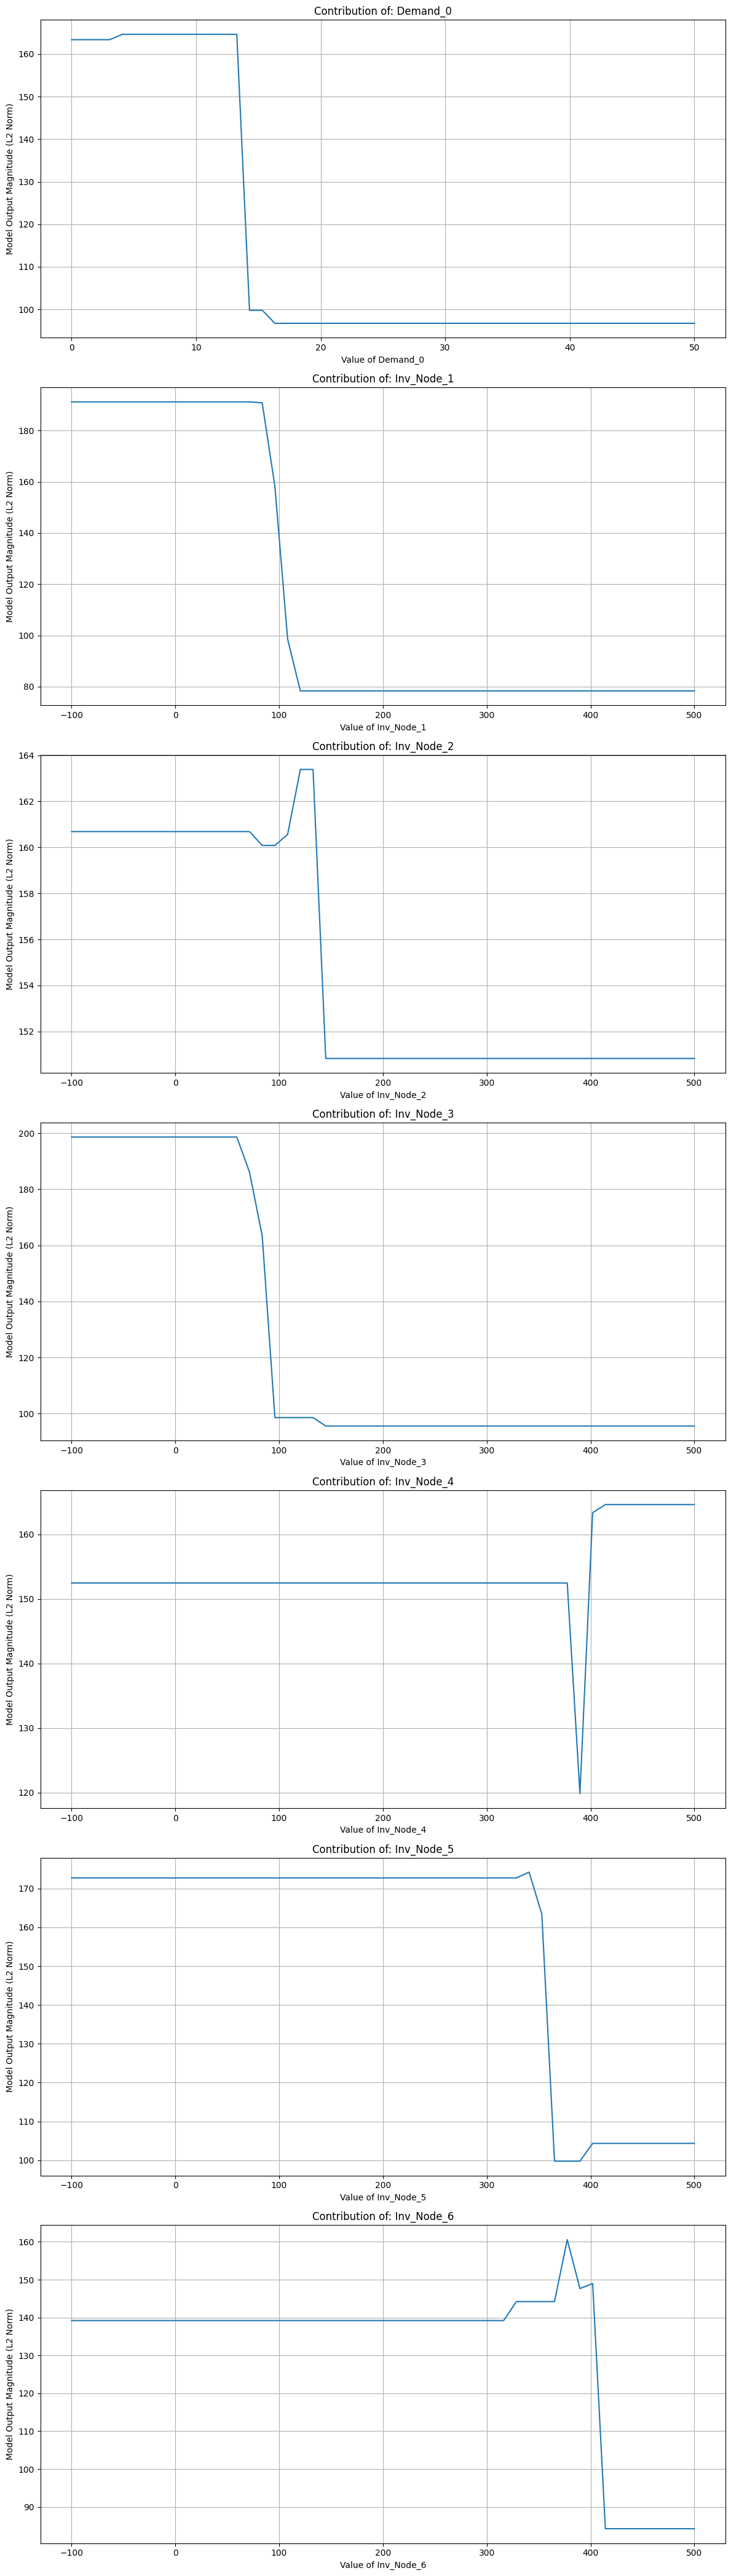


Plotting a selection of Pipeline Effects...


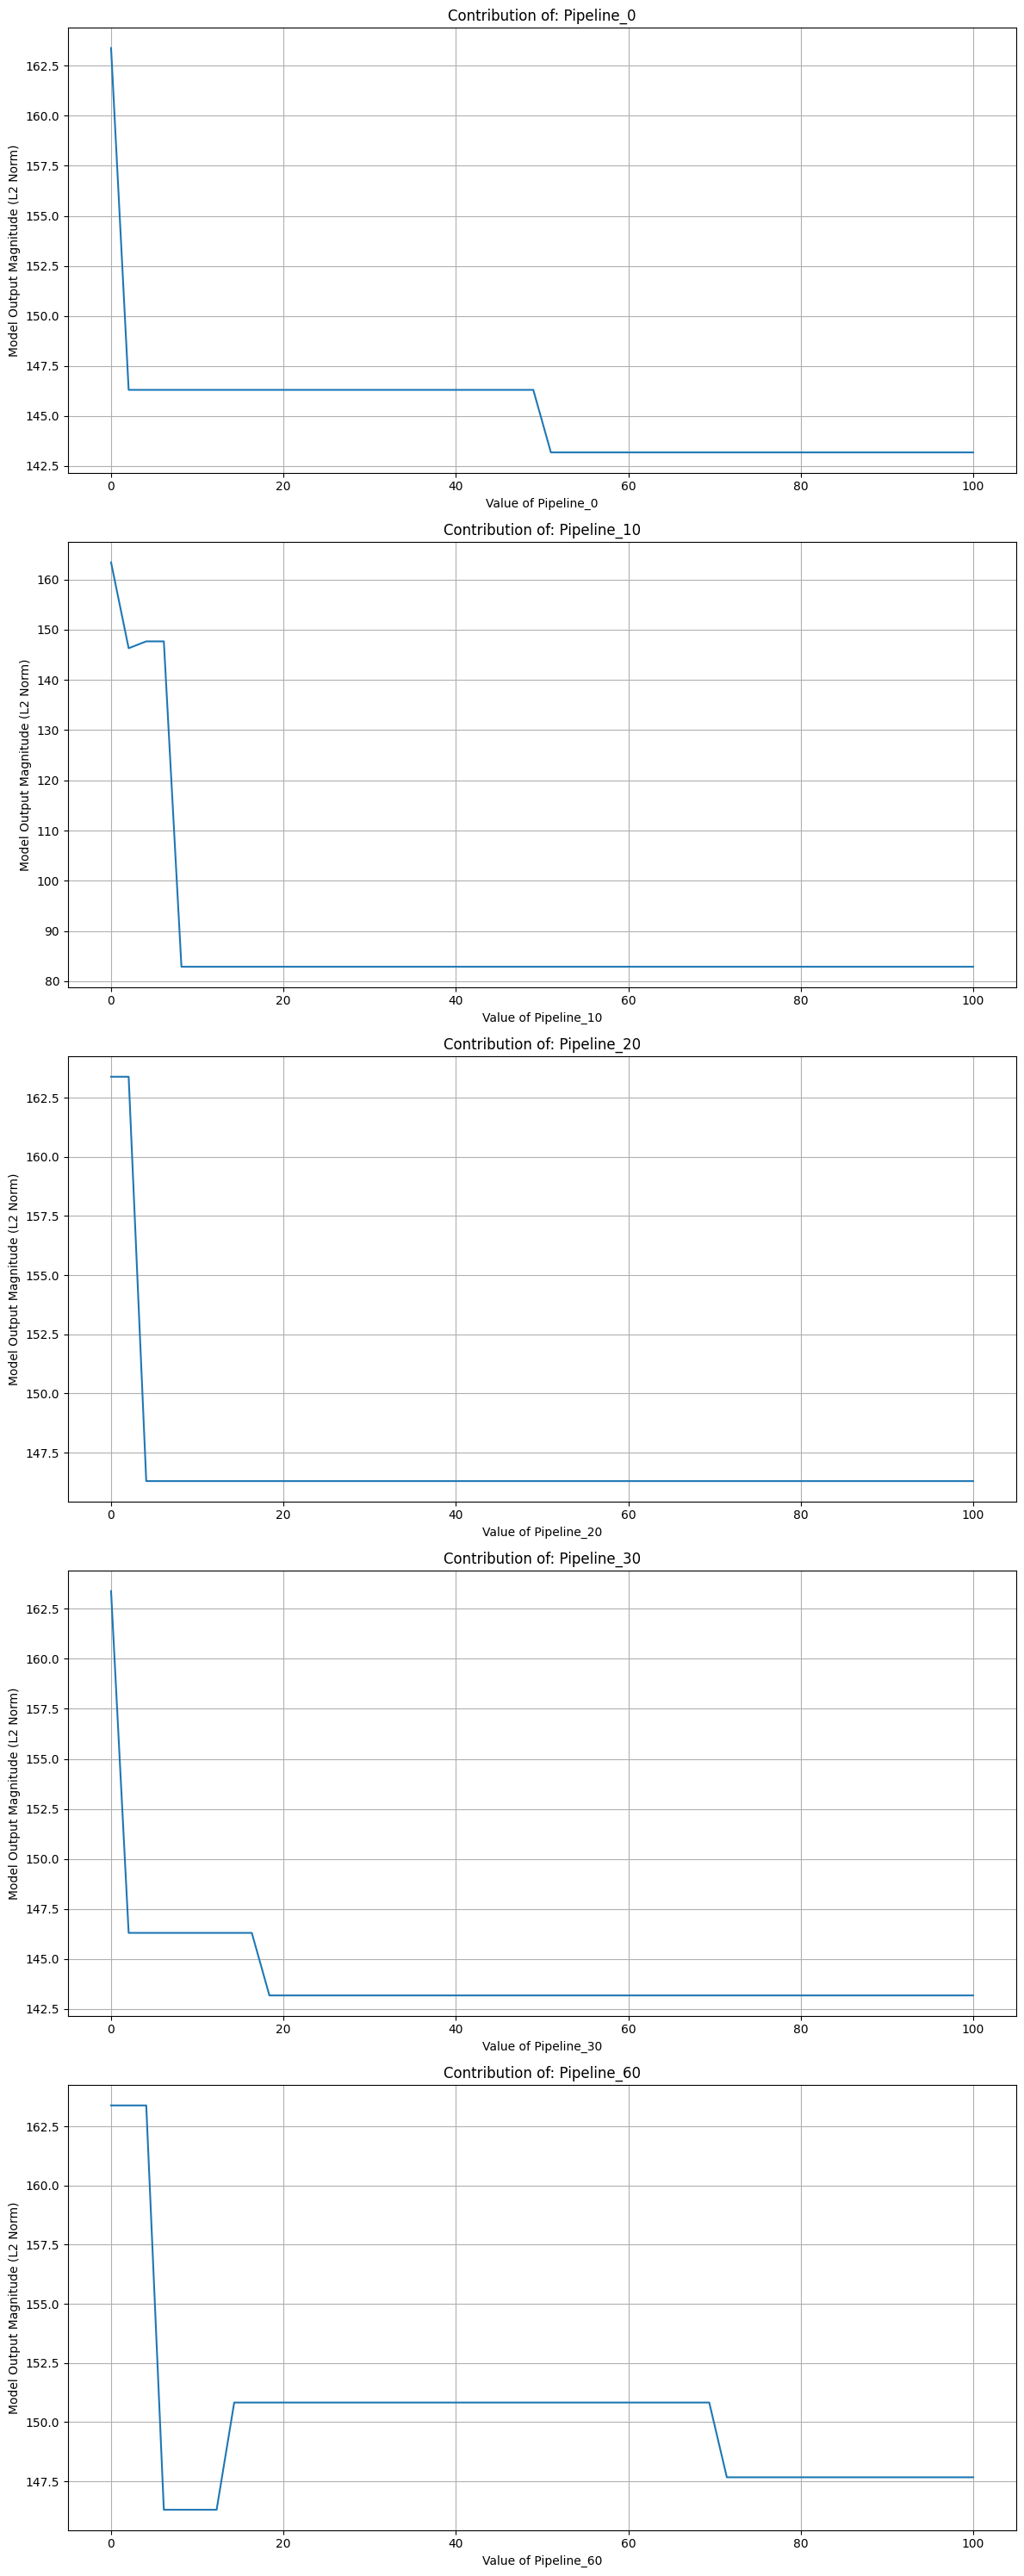

In [25]:
print("\nGenerating interpretability plots using ICE method...")

# --- 5.1. Get the trained model and helper objects ---
trained_policy = agent.get_policy()
nodegam_model = trained_policy.model.node_model
device = next(nodegam_model.parameters()).device

# --- 5.2. Create baseline data and feature info ---
print("Creating a sample environment to generate baseline data...")
env = create_env(env_name)(env_name)
initial_obs = env.reset()
baseline_obs = torch.tensor(initial_obs, dtype=torch.float32).unsqueeze(0).to(device)

# --- 5.3. Create full list of feature names ---
num_demand_features = len(env.retail_links)
num_inv_features = len(env.main_nodes)
num_pipeline_features = env.pipeline_length

feature_names = ([f"Demand_{i}" for i in range(num_demand_features)] +
                 [f"Inv_Node_{node}" for node in env.main_nodes] +
                 [f"Pipeline_{i}" for i in range(num_pipeline_features)])

# --- 5.4. Plot Main Effects (Demand and Inventory) ---
num_main_features = num_demand_features + num_inv_features
main_feature_ranges = ([np.linspace(0, 50, 50)] * num_demand_features + 
                       [np.linspace(-100, 500, 50)] * num_inv_features)

fig, axes = plt.subplots(nrows=num_main_features, ncols=1, figsize=(12, 6 * num_main_features))
print("Plotting Main Effects (Demand and Inventory)...")
for i in range(num_main_features):
    x_range = main_feature_ranges[i]
    plot_batch = baseline_obs.repeat(len(x_range), 1)
    plot_batch[:, i] = torch.tensor(x_range, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        y_tensor = nodegam_model(plot_batch)
    y_vals = torch.norm(y_tensor, dim=1).cpu().numpy()
    
    ax = axes[i]
    ax.plot(x_range, y_vals)
    ax.set_title(f"Contribution of: {feature_names[i]}")
    ax.set_xlabel(f"Value of {feature_names[i]}")
    ax.set_ylabel("Model Output Magnitude (L2 Norm)")
    ax.grid(True)

plt.tight_layout()
plt.show()

# --- 5.5. Plot a Selection of Pipeline Effects ---
print("\nPlotting a selection of Pipeline Effects...")

# We can't plot all 61 pipeline features, so let's select a few representative ones.
# For example: the first, a few from the middle, and the last.
pipeline_indices_to_plot = [0, 10, 20, 30, 60] 
# Note: The total number of pipeline features is 61 (indices 0-60)

pipeline_range = np.linspace(0, 100, 50) # A reasonable range for units in transit

fig, axes = plt.subplots(nrows=len(pipeline_indices_to_plot), ncols=1, 
                         figsize=(12, 6 * len(pipeline_indices_to_plot)))

for idx, pipeline_idx in enumerate(pipeline_indices_to_plot):
    # The actual index in the full observation vector
    feature_index = num_main_features + pipeline_idx
    
    x_range = pipeline_range
    plot_batch = baseline_obs.repeat(len(x_range), 1)
    plot_batch[:, feature_index] = torch.tensor(x_range, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        y_tensor = nodegam_model(plot_batch)
    y_vals = torch.norm(y_tensor, dim=1).cpu().numpy()
    
    ax = axes[idx]
    ax.plot(x_range, y_vals)
    ax.set_title(f"Contribution of: {feature_names[feature_index]}")
    ax.set_xlabel(f"Value of {feature_names[feature_index]}")
    ax.set_ylabel("Model Output Magnitude (L2 Norm)")
    ax.grid(True)

plt.tight_layout()
plt.show()


Generating interpretability plots...

--- Inspecting Learned Model Structure ---
Detected 0 main effects.
Detected 0 pairwise interactions.

Plotting Main Effects...


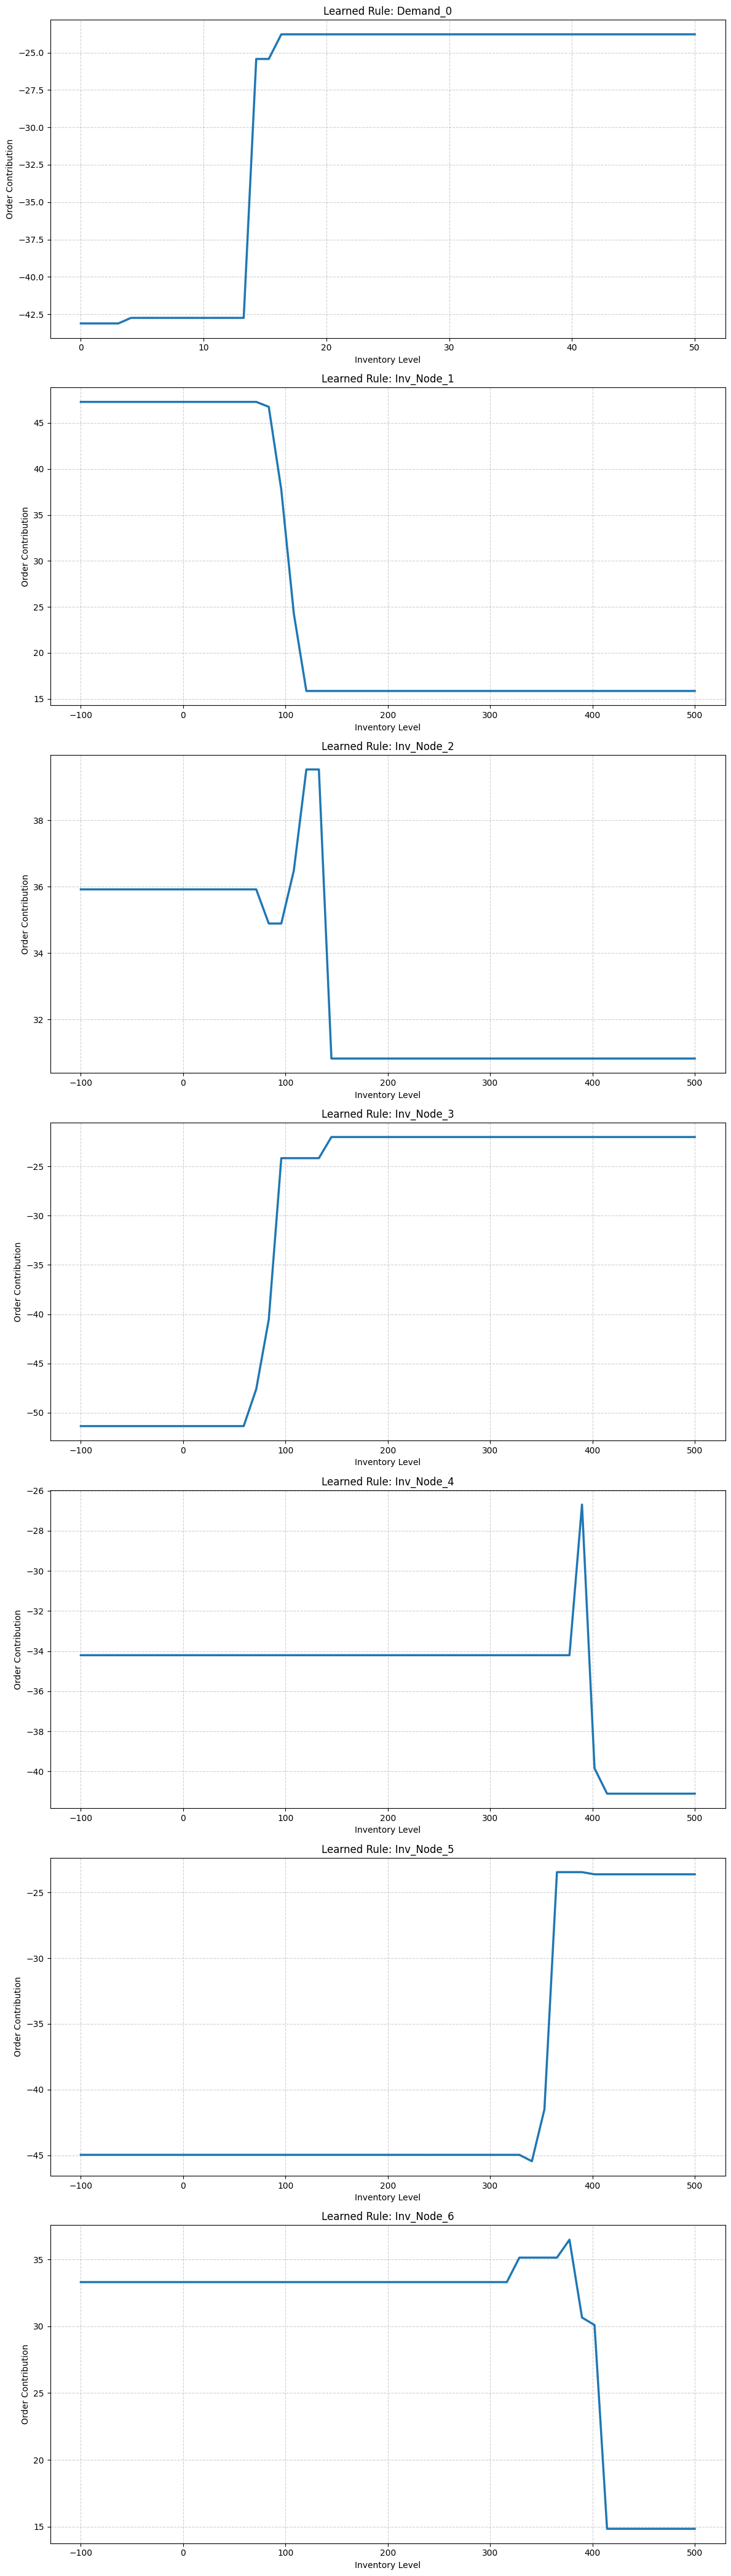


No pairwise interactions were learned by the model to plot.


In [42]:
print("\nGenerating interpretability plots...")

# --- 5.1. Get model and helper objects ---
trained_policy = agent.get_policy()
nodegam_model = trained_policy.model.node_model
device = next(nodegam_model.parameters()).device

env = create_env(env_name)(env_name)
initial_obs = env.reset()
baseline_obs = torch.tensor(initial_obs, dtype=torch.float32).unsqueeze(0).to(device)
feature_names = ([f"Demand_{i}" for i in range(len(env.retail_links))] +
                 [f"Inv_Node_{node}" for node in env.main_nodes] +
                 [f"Pipeline_{i}" for i in range(env.pipeline_length)])

# --- 5.2. Inspect the Learned Additive Terms ---
print("\n--- Inspecting Learned Model Structure ---")
learned_terms = nodegam_model.get_additive_terms()

main_effects_indices = [term for term in learned_terms if isinstance(term, int)]
interaction_indices = [term for term in learned_terms if isinstance(term, tuple)]

print(f"Detected {len(main_effects_indices)} main effects.")
print(f"Detected {len(interaction_indices)} pairwise interactions.")
if interaction_indices:
    print("Interaction pairs (by feature index):", interaction_indices)

# --- 5.3. Plot Main Effects (1D Plots) ---
# ... (This plotting code for 1D effects is the same as the previous answer) ...
# ... I'll include it here for completeness ...
num_main_features = len(env.retail_links) + len(env.main_nodes)
main_feature_ranges = ([np.linspace(0, 50, 50)] + [np.linspace(-100, 500, 50)] * 6)
fig, axes = plt.subplots(nrows=num_main_features, ncols=1, figsize=(12, 6 * num_main_features))
print("\nPlotting Main Effects...")
for i in range(num_main_features):
    x_range, ax = main_feature_ranges[i], axes[i]
    
    # 1. Create the batch
    plot_batch = baseline_obs.repeat(len(x_range), 1)
    plot_batch[:, i] = torch.tensor(x_range, dtype=torch.float32).to(device)
    
    # 2. Run Model
    with torch.no_grad():
        y_tensor = nodegam_model(plot_batch)
    y_vals = y_tensor.cpu().numpy() # Shape: [50, Num_Actions]
    
    # 3. SMART SELECTION: Find the action with the most movement (Variance)
    # We calculate the standard deviation of each column (action)
    action_variance = np.std(y_vals, axis=0)
    
    # Get the index of the action that changes the most
    best_action_idx = np.argmax(action_variance)
    
    # Check if the line is actually moving (variance > threshold)
    if action_variance[best_action_idx] < 0.01:
        # If nothing moves, just plot the first one and say "No Effect"
        ax.plot(x_range, y_vals[:, 0], color='gray', alpha=0.5)
        ax.text(0.5, 0.5, "No Impact", transform=ax.transAxes, ha='center')
    else:
        # 4. PLOT ONLY THE RELEVANT LINE
        # We plot the "Best Action" in bold color
        relevant_line = y_vals[:, best_action_idx]
        ax.plot(x_range, relevant_line, color='#1f77b4', linewidth=2.5)
        
        # 5. FIND THE "SWITCH POINT" (Optional Fancy visual)
        # Find where the biggest drop happens (derivative)
        gradient = np.gradient(relevant_line)
        switch_idx = np.argmax(np.abs(gradient))
        switch_val = x_range[switch_idx]
        

    # Formatting
    ax.set_title(f"Learned Rule: {feature_names[i]}") # Better Title
    ax.set_xlabel(f"Inventory Level")
    ax.set_ylabel("Order Contribution")
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# --- 5.4. Plot Detected Pairwise Interactions (2D Heatmaps) ---
if not interaction_indices:
    print("\nNo pairwise interactions were learned by the model to plot.")
else:
    print("\nPlotting Detected Pairwise Interactions...")
    for pair_idx in interaction_indices:
        feat1_idx, feat2_idx = pair_idx
        
        # Define ranges for the two features in the interaction
        feat1_range = np.linspace(-100, 500, 30)
        feat2_range = np.linspace(-100, 500, 30)
        X, Y = np.meshgrid(feat1_range, feat2_range)
        
        # Create a batch by varying these two features from the baseline
        grid_size = len(feat1_range) * len(feat2_range)
        plot_batch = baseline_obs.repeat(grid_size, 1)
        plot_batch[:, feat1_idx] = torch.tensor(X.ravel(), dtype=torch.float32).to(device)
        plot_batch[:, feat2_idx] = torch.tensor(Y.ravel(), dtype=torch.float32).to(device)

        with torch.no_grad():
            y_tensor = nodegam_model(plot_batch)
        
        Z = torch.norm(y_tensor, dim=1).cpu().numpy().reshape(X.shape)

        # Create the heatmap
        plt.figure(figsize=(10, 8))
        plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis')
        plt.colorbar(label="Model Output Magnitude (L2 Norm)")
        plt.title(f"Interaction between: {feature_names[feat1_idx]} & {feature_names[feat2_idx]}")
        plt.xlabel(f"Value of {feature_names[feat1_idx]}")
        plt.ylabel(f"Value of {feature_names[feat2_idx]}")
        plt.grid(True)
        plt.show()


2025-11-26 17:55:29,976	WARNING util.py:39 -- Install gputil for GPU system monitoring.
2025-11-26 17:55:30,002	INFO trainable.py:481 -- Restored on 192.168.2.116 from checkpoint: C:\Users\24608\ray_results\PPO_NetworkManagement-v0_2025-11-10_21-16-01k5703a4k\checkpoint_300\checkpoint-300
2025-11-26 17:55:30,010	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 18347.14482998848, '_episodes_total': 40000}
2025-11-26 17:55:30,053	WARNING util.py:39 -- Install gputil for GPU system monitoring.
2025-11-26 17:55:30,059	INFO trainable.py:481 -- Restored on 192.168.2.116 from checkpoint: C:\Users\24608\ray_results\PPO_NetworkManagement-v0_2025-11-10_21-16-01k5703a4k\checkpoint_300\checkpoint-300
2025-11-26 17:55:30,059	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 18347.14482998848, '_episodes_total': 40000}
2025-11-26 17:55:30,102	WARNING util.py:39 -- In

2025-11-26 17:55:30,115	INFO trainable.py:481 -- Restored on 192.168.2.116 from checkpoint: C:\Users\24608\ray_results\PPO_NetworkManagement-v0_2025-11-10_21-16-01k5703a4k\checkpoint_300\checkpoint-300
2025-11-26 17:55:30,116	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 18347.14482998848, '_episodes_total': 40000}
2025-11-26 17:55:30,151	WARNING util.py:39 -- Install gputil for GPU system monitoring.
2025-11-26 17:55:30,160	INFO trainable.py:481 -- Restored on 192.168.2.116 from checkpoint: C:\Users\24608\ray_results\PPO_NetworkManagement-v0_2025-11-10_21-16-01k5703a4k\checkpoint_300\checkpoint-300
2025-11-26 17:55:30,161	INFO trainable.py:489 -- Current state after restoring: {'_iteration': 300, '_timesteps_total': None, '_time_total': 18347.14482998848, '_episodes_total': 40000}
2025-11-26 17:55:30,194	WARNING util.py:39 -- Install gputil for GPU system monitoring.
2025-11-26 17:55:30,203	INFO trainable.py:481 --

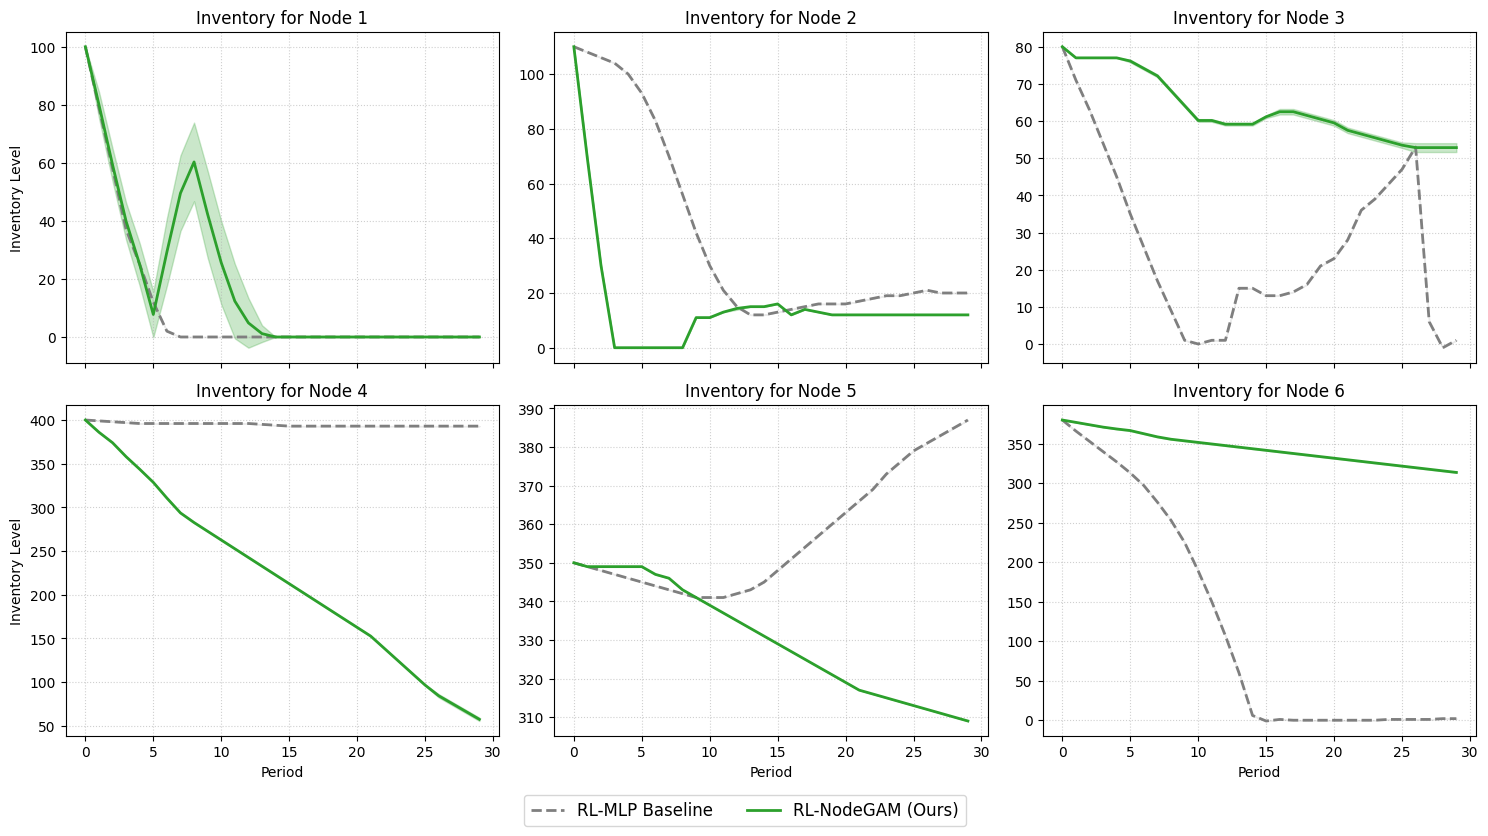

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import or_gym
import pandas as pd


env_name = 'NetworkManagement-v0'
env = or_gym.make(env_name)
num_episodes = 20  
num_periods = 30    
nodes_to_plot = [1, 2, 3, 4, 5, 6] 

def get_inventory_levels(env, node_ids):
    """
    In this specific OR-Gym environment, inventory is stored in 'env.X',
    which is a Pandas DataFrame.
    """
    raw_env = env.unwrapped
    current_t = raw_env.period
    
    current_vals = []
    for n in node_ids:
        try:
            val = raw_env.X.loc[current_t, n]
        except:
            val = 0 
        current_vals.append(val)
        
    return current_vals



def collect_data(policy_function, env, episodes, periods, node_ids):
    all_history = np.zeros((episodes, periods, len(node_ids)))
    
    for ep in range(episodes):
        obs = env.reset()
        for t in range(periods):
            current_inv = get_inventory_levels(env, node_ids)
            all_history[ep, t, :] = current_inv
            action = policy_function(obs)
            obs, reward, done, _ = env.step(action)
            if done: break
            
    return all_history


def gam_policy(obs):
    action = agent.compute_action(obs, explore=False)
    return action

def baseline_policy(obs):
    baseline_config = dict(
    env=env_name,
    num_workers=0,
    env_config=env_config,
    

    model=dict(
        fcnet_hiddens=[32, 32],
        fcnet_activation='relu'
    ),
    

    lr=5e-5,
    gamma=0.99, 
    

    train_batch_size=4000,
    sgd_minibatch_size=128,
    num_sgd_iter=10,
    

    horizon=200, 
    
    framework="torch",
    num_gpus=0, 
    )
    
    baseline_agent = PPOTrainer(config=baseline_config, env="NetworkManagement-v0")
    checkpoint_path = r"C:\Users\24608\ray_results\PPO_NetworkManagement-v0_2025-11-10_21-16-01k5703a4k\checkpoint_300\checkpoint-300" #change this to your actual path
    baseline_agent.restore(checkpoint_path)
    return baseline_agent.compute_action(obs, explore=False)


print("Collecting GAM Data...")
gam_data = collect_data(gam_policy, env, num_episodes, num_periods, nodes_to_plot)

print("Collecting Baseline Data...")
baseline_data = collect_data(baseline_policy, env, num_episodes, num_periods, nodes_to_plot)


def plot_inventory_profiles(data_dict, node_ids):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
    axes = axes.flatten() 
    
    periods = np.arange(data_dict[list(data_dict.keys())[0]].shape[1])
    
    for i, node_id in enumerate(node_ids):
        ax = axes[i]
        
        for model_name, dataset in data_dict.items():
            node_data = dataset[:, :, i] 
            
            mean_inv = np.mean(node_data, axis=0)
            std_inv = np.std(node_data, axis=0)
            
            if 'GAM' in model_name:
                color = '#2ca02c'
                style = '-'
                alpha = 0.25
            else:
                color = '#7f7f7f'
                style = '--'
                alpha = 0.15
            
            ax.plot(periods, mean_inv, label=model_name, color=color, linestyle=style, linewidth=2)
            ax.fill_between(periods, mean_inv - std_inv, mean_inv + std_inv, color=color, alpha=alpha)
        
        ax.set_title(f"Inventory for Node {node_id}")
        ax.grid(True, linestyle=':', alpha=0.6)
        if i in [0, 3]: ax.set_ylabel("Inventory Level")
        if i in [3, 4, 5]: ax.set_xlabel("Period")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05), fontsize=12)
    plt.tight_layout()
    plt.show()


plot_inventory_profiles({
    'RL-MLP Baseline': baseline_data,
    'RL-NodeGAM (Ours)': gam_data
}, nodes_to_plot)